In [19]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from collections import Counter

In [20]:
#resize board image to (640, 640)
def resize_board_image(img_path):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    img.save(img_path)
    return img_path

In [21]:
#turn grayscale; size 1D output
def grayscale(board):
    #grayscale value
    #RGB Value to grayscale formula (NTSC):
    #0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue
    board_gray = []
    for i in range(board.shape[0]):
        board_gray_row = []
        for j in range (board.shape[1]):
            r = board[i,j,0]
            g = board[i,j,1]
            b = board[i,j,2]
            board_gray_row.append(0.299*r + 0.587*g + 0.114*b)
        board_gray.append(board_gray_row)
    return np.array(board_gray)

In [22]:
#isolate each square on board
def get_squares(board):
    squares = []
    square_width = int(board.shape[0]/8)
    square_height = int(board.shape[1]/8)
    for i in range(8):
        squares_row = []
        for j in range (8):
            square = board[(square_height*i):(square_height*(i+1)), (square_width*j):(square_width*(j+1))]
            squares_row.append(square)
        squares.append(squares_row)
    return np.array(squares)

In [23]:
#crop out border
def crop(source, value):
    square = []
    for i in range(int(source.shape[0]*value), int(source.shape[0]*(1-value))):
        square_row = []
        for j in range (int(source.shape[0]*value), int(source.shape[0]*(1-value))):
            square_row.append(source[i][j])
        square.append(square_row)
    return np.array(square)

In [24]:
#save piece as txt file
def save_txt(square, save_path, tag, num):
    if num < 10:
        np.savetxt(f"{save_path}/{tag}00{num}.txt", square, delimiter =" ")
    elif num < 100:
        np.savetxt(f"{save_path}/{tag}0{num}.txt", square, delimiter =" ")
    else:
        np.savetxt(f"{save_path}/{tag}{num}.txt", square, delimiter =" ")

In [25]:
#get pieces from board
def get_board_pieces(path):
    #initialize number tags
    lb = 0
    db = 0
    lw = 0
    dw = 0
    
    for board_name in os.listdir(path):
        board_path = f"{path}/{board_name}"
        board = imread(resize_board_image(board_path))
        squares = get_squares(grayscale(board))
        #black pieces
        for i in range(8):
            if i%2 == 0: #even index -> light square
                lb += 1
                save_txt(crop(squares[0, i], 0.125), "light_squares_txt/black_pieces_txt", "lb", lb)
            else:
                db += 1
                save_txt(crop(squares[0, i], 0.125), "dark_squares_txt/black_pieces_txt", "db", db)
        #get pawn for each square color
        db += 1
        save_txt(crop(squares[1, 0], 0.125), "dark_squares_txt/black_pieces_txt", "db", db)
        lb += 1
        save_txt(crop(squares[1, 1], 0.125), "light_squares_txt/black_pieces_txt", "lb", lb)

        #white pieces
        for i in range(8):
            if i%2 == 0: #even index -> dark square
                dw += 1
                save_txt(crop(squares[7, i], 0.125), "dark_squares_txt/white_pieces_txt", "dw", dw)
            else:
                lw += 1
                save_txt(crop(squares[7, i], 0.125), "light_squares_txt/white_pieces_txt", "lw", lw)
        #get pawn for each square color
        lw += 1
        save_txt(crop(squares[6, 0], 0.125), "light_squares_txt/white_pieces_txt", "lw", lw)
        dw += 1
        save_txt(crop(squares[6, 1], 0.125), "dark_squares_txt/white_pieces_txt", "dw", dw)

In [26]:
def prewitt(square):
    square_height, square_width = square.shape
    #prewitt kernel
    h_filter = np.array([[-1, 0, 1], 
                        [-1, 0, 1], 
                        [-1, 0, 1]])
    v_filter = np.array([[-1, -1, -1], 
                        [ 0,  0,  0], 
                        [ 1,  1,  1]])

    #initialize gradient image
    gradient_image = np.zeros((square_height, square_width))

    for i in range(1, square_height - 1):
        for j in range(1, square_width - 1):
            h_value = (h_filter[0, 0] * square[i - 1, j - 1]) + \
                      (h_filter[0, 1] * square[i - 1, j]) + \
                      (h_filter[0, 2] * square[i - 1, j + 1]) + \
                      (h_filter[1, 0] * square[i, j - 1]) + \
                      (h_filter[1, 1] * square[i, j]) + \
                      (h_filter[1, 2] * square[i, j + 1]) + \
                      (h_filter[2, 0] * square[i + 1, j - 1]) + \
                      (h_filter[2, 1] * square[i + 1, j]) + \
                      (h_filter[2, 2] * square[i + 1, j + 1])

            v_value = (v_filter[0, 0] * square[i - 1, j - 1]) + \
                      (v_filter[0, 1] * square[i - 1, j]) + \
                      (v_filter[0, 2] * square[i - 1, j + 1]) + \
                      (v_filter[1, 0] * square[i, j - 1]) + \
                      (v_filter[1, 1] * square[i, j]) + \
                      (v_filter[1, 2] * square[i, j + 1]) + \
                      (v_filter[2, 0] * square[i + 1, j - 1]) + \
                      (v_filter[2, 1] * square[i + 1, j]) + \
                      (v_filter[2, 2] * square[i + 1, j + 1])
            #value per pixel in gradient image
            magnitude = np.sqrt(pow(h_value, 2) + pow(v_value, 2))
            gradient_image[i - 1, j - 1] = magnitude
    return gradient_image

In [27]:
#get feature vector
def feature_vector(array): #ndarray input
    return np.reshape(array, array.size)

In [28]:
#"distance" from avg_img
def euclidean_distance(v1, v2): #ndarray inputs
    if(v1.size != v2.size):
        print("Error")
    squared_differences = 0
    for i in range(v1.size):
        squared_differences += pow((v1[i] - v2[i]), 2)
    return np.sqrt(squared_differences)

In [29]:
#create "average image" for each: db, dw, lb, lw
def get_avg_img():
    #dark_squares
    #db
    avg_img_db = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/black_pieces_txt"):
        array = np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}")
        avg_img_db += array
        n += 1
    avg_img_db /= n
    #dw
    avg_img_dw = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/white_pieces_txt"):
        array = np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}")
        avg_img_dw += array
        n += 1
    avg_img_dw /= n

    #light_squares
    #lb
    avg_img_lb = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("light_squares_txt/black_pieces_txt"):
        array = np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}")
        avg_img_lb += array
        n += 1
    avg_img_lb /= n
    #lw
    avg_img_lw = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("light_squares_txt/white_pieces_txt"):
        array = np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}")
        avg_img_lw += array
        n += 1
    avg_img_lw /= n
    
    return [avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw]

In [30]:
#get distance of each sample
def get_distances(avg_img_fvector, folder_path):
    distances = []
    for image in os.listdir(folder_path):
        img_fvector = feature_vector(np.loadtxt(f"{folder_path}/{image}"))
        distances.append(euclidean_distance(avg_img_fvector, img_fvector))
    return np.array(distances)

In [31]:
#get "average image" of prewitts of each piece type
def get_avg_prewitt():
    def get_avg(db, dw, lb, lw):
        #position > 4 = skip
        avg = np.zeros((60, 60))
        n = 0
        #db
        if db > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"dark_squares_txt/black_pieces_txt")):
                if i%5 == db:
                    array = prewitt(np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        #dw
        if dw > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"dark_squares_txt/white_pieces_txt")):
                if i%5 == dw:
                    array = prewitt(np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        #lb
        if lb > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"light_squares_txt/black_pieces_txt")):
                if i%5 == lb:
                    array = prewitt(np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        #lw
        if lw > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"light_squares_txt/white_pieces_txt")):
                if i%5 == lw:
                    array = prewitt(np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        avg /= n
        return avg
    
#     (db, dw, lb, lw) positions based on get_board_pieces()
#     p: n%5==4 all (4,4,4,4)
#     r: n%5==3 db, lw; n%5==0 dw, lb (3, 0, 0, 3)
#     n: n%5==0 db, lw; n%5==3 dw, lb (0, 3, 3, 0)
#     b: n%5==2 db, lw; n%5==1 dw, lb (2, 1, 1, 2)
#     k: n%5==1 dw; n%5==2 lb (5, 1, 2, 5)
#     q: n%5==1 db; n%5==2 lw (1, 5, 5, 2)

    avg_p_p = get_avg(4, 4, 4, 4)
    avg_p_r = get_avg(3, 0, 0, 3)
    avg_p_n = get_avg(0, 3, 3, 0)
    avg_p_b = get_avg(2, 1, 1, 2)
    avg_p_k = get_avg(5, 2, 2, 5)
    avg_p_q = get_avg(1, 5, 5, 1)

    return [avg_p_p, avg_p_r, avg_p_n, avg_p_b, avg_p_k, avg_p_q]

In [32]:
#points: (p, r, n, b, k, q) each dimension are distances to each corresponding piece avg_prewitt
def get_prewitt_distances(db, dw, lb, lw, avg_prewitt):
    #position > 4 = skip
    prewitt_distances = []
    #db
    if db > 4:
        pass
    else:
        for i,txt in enumerate(os.listdir(f"dark_squares_txt/black_pieces_txt")):
            if i%5 == db:
                array = prewitt(np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}"))
                prewitt_distances.append(euclidean_distance(feature_vector(array), feature_vector(avg_prewitt)))
    #dw
    if dw > 4:
        pass
    else:
        for i,txt in enumerate(os.listdir(f"dark_squares_txt/white_pieces_txt")):
            if i%5 == dw:
                array = prewitt(np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}"))
                prewitt_distances.append(euclidean_distance(feature_vector(array), feature_vector(avg_prewitt)))
    #lb
    if lb > 4:
        pass
    else:
        for i,txt in enumerate(os.listdir(f"light_squares_txt/black_pieces_txt")):
            if i%5 == lb:
                array = prewitt(np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}"))
                prewitt_distances.append(euclidean_distance(feature_vector(array), feature_vector(avg_prewitt)))
    #lw
    if lw > 4:
        pass
    else:
        for i,txt in enumerate(os.listdir(f"light_squares_txt/white_pieces_txt")):
            if i%5 == lw:
                array = prewitt(np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}"))
                prewitt_distances.append(euclidean_distance(feature_vector(array), feature_vector(avg_prewitt)))
    return np.array(prewitt_distances)

In [33]:
#binary classifier for piece color
class SVM:

    def __init__(self, learning_rate=0.001, reg=0.01):
        self.weights = None
        self.bias = None
        self.learning_rate = learning_rate
        self.reg = reg
        
    def fit(self, X, y): #X & y as ndarrays
        n_samples, n_features = X.shape

        y_labels = np.where(y <= 0, -1, 1) #class labels

        #init weights and bias; can be randomized
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        #fitting
        for _ in range(10000): #no. of iterations can be changed
            for i, x_i in enumerate(X):
                if y_labels[i] * (np.dot(x_i, self.weights) - self.bias) >= 1:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights - np.dot(x_i, y_labels[i]))
                    self.bias -= self.learning_rate * y_labels[i]


    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [34]:
#draw plot: training data, support vectors, decision boundary
def visualize_svm(svm, X, y):
    def get_hyperplane_value(x, weights, bias, offset):
        return (-weights[0] * x + bias + offset) / weights[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor("khaki")
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, cmap="gray")
    plt.xlabel("Distance from Black Avg")
    plt.ylabel("Distance from White Avg")

    dx_1 = np.amin(X[:, 0])
    dx_2 = np.amax(X[:, 0])

    dy_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, 0)
    dy_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, 0)

    by_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, -1)
    by_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, -1)

    wy_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, 1)
    wy_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, 1)

    ax.plot([dx_1, dx_2], [dy_1, dy_2], "y--") # decision boundary
    ax.plot([dx_1, dx_2], [by_1, by_2], "k") # black sv 
    ax.plot([dx_1, dx_2], [wy_1, wy_2], "w") # white sv
    
    dy_min = np.amin(X[:, 1])
    dy_max = np.amax(X[:, 1])
    ax.set_ylim([dy_min - 3, dy_max + 3])

    plt.show()

In [35]:
#multi-class classifier for piece type
class KNN:
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
        
    def _predict(self, x):
        #get distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        #get closest k neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        #majority vote
        return Counter(k_nearest_labels).most_common()[0][0]

In [36]:
#compute accuracy
def accuracy(actual, predictions):
    return np.sum(actual == predictions) / len(actual)

In [76]:
#run only when there are new boards
# get_board_pieces("boards")
# get_empty_squares("boards")

In [52]:
avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw = get_avg_img()

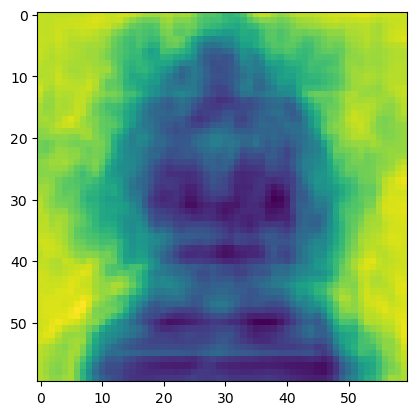

In [21]:
plt.imshow(avg_img_db)

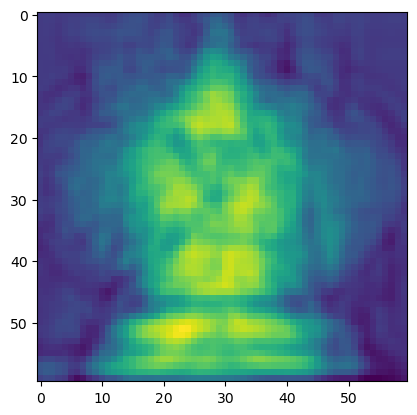

In [22]:
plt.imshow(avg_img_dw)

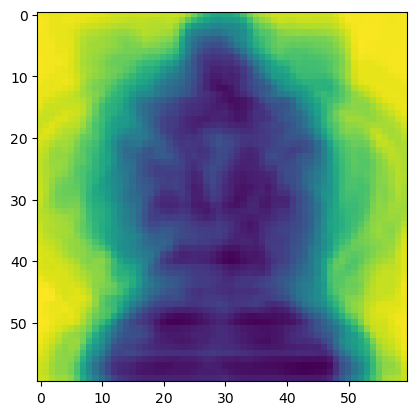

In [23]:
plt.imshow(avg_img_lb)

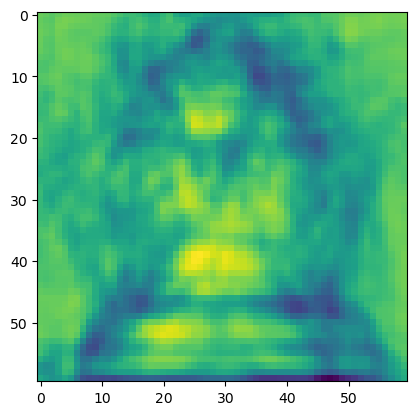

In [24]:
plt.imshow(avg_img_lw)

In [25]:
#export avg_imgs
np.savetxt("ndarray_txt/avg_img_db.txt", avg_img_db, delimiter = " ")
np.savetxt("ndarray_txt/avg_img_dw.txt", avg_img_dw, delimiter = " ")
np.savetxt("ndarray_txt/avg_img_lb.txt", avg_img_lb, delimiter = " ")
np.savetxt("ndarray_txt/avg_img_lw.txt", avg_img_lw, delimiter = " ")

In [53]:
#x: distance to avg_img_db; y: distance to avg_img_dw
#dark 
d_b_to_b = get_distances(feature_vector(avg_img_db), "dark_squares_txt/black_pieces_txt")
d_b_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares_txt/black_pieces_txt")
d_w_to_b = get_distances(feature_vector(avg_img_db), "dark_squares_txt/white_pieces_txt")
d_w_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares_txt/white_pieces_txt")
db = np.array([(lambda i: np.array([d_b_to_b[i], d_b_to_w[i]]))(i) for i in range(d_b_to_b.size)])
dw = np.array([(lambda i: np.array([d_w_to_b[i], d_w_to_w[i]]))(i) for i in range(d_w_to_b.size)])
x_ds_train = np.concatenate((db, dw),axis=0)
y_ds_train = np.append((np.ones(db.shape[0])*-1), np.ones(dw.shape[0]))

###########################

# light
l_b_to_b = get_distances(feature_vector(avg_img_lb), "light_squares_txt/black_pieces_txt")
l_b_to_w = get_distances(feature_vector(avg_img_lw), "light_squares_txt/black_pieces_txt")
l_w_to_b = get_distances(feature_vector(avg_img_lb), "light_squares_txt/white_pieces_txt")
l_w_to_w = get_distances(feature_vector(avg_img_lw), "light_squares_txt/white_pieces_txt")
lb = np.array([(lambda i: np.array([l_b_to_b[i], l_b_to_w[i]]))(i) for i in range(l_b_to_b.size)])
lw = np.array([(lambda i: np.array([l_w_to_b[i], l_w_to_w[i]]))(i) for i in range(l_w_to_b.size)])
x_ls_train = np.concatenate((lb, lw),axis=0)
y_ls_train = np.append((np.ones(lb.shape[0])*-1), np.ones(lw.shape[0]))

SVM classification accuracy 0.96


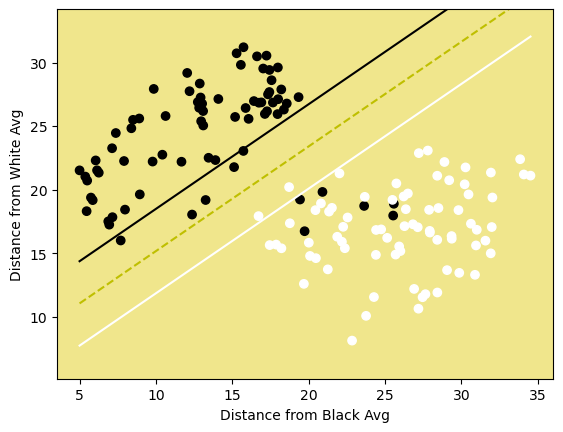

In [54]:
#TEST Training

#dark squares
d_svm = SVM()
d_svm.fit(x_ds_train, y_ds_train)
predictions = d_svm.predict(x_ds_train)
print("SVM classification accuracy", accuracy(y_ds_train, predictions))
visualize_svm(d_svm, x_ds_train, y_ds_train)

SVM classification accuracy 0.9466666666666667


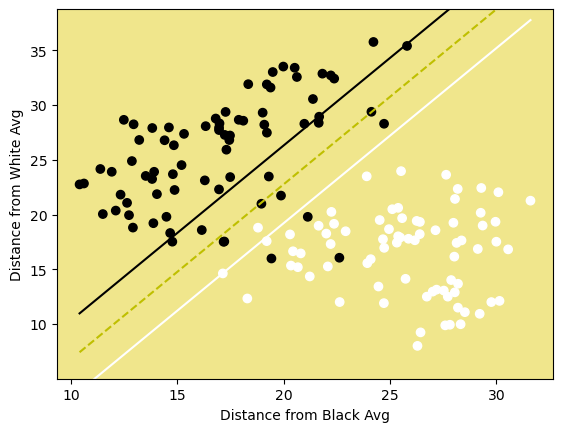

In [28]:
#light squares
l_svm = SVM()
l_svm.fit(x_ls_train, y_ls_train)
predictions = l_svm.predict(x_ls_train)
print("SVM classification accuracy", accuracy(y_ls_train, predictions))
visualize_svm(l_svm, x_ls_train, y_ls_train)

In [29]:
#export SVM attributes

#DS_SVM
np.savetxt("ndarray_txt/d_svm.txt", np.array([d_svm.weights[0], d_svm.weights[1], d_svm.bias, d_svm.learning_rate, d_svm.reg]), delimiter = " ")
#LS_SVM
np.savetxt("ndarray_txt/l_svm.txt", np.array([l_svm.weights[0], l_svm.weights[1], l_svm.bias, l_svm.learning_rate, l_svm.reg]), delimiter = " ")

In [34]:
avg_p_p, avg_p_r, avg_p_n, avg_p_b, avg_p_k, avg_p_q = get_avg_prewitt()

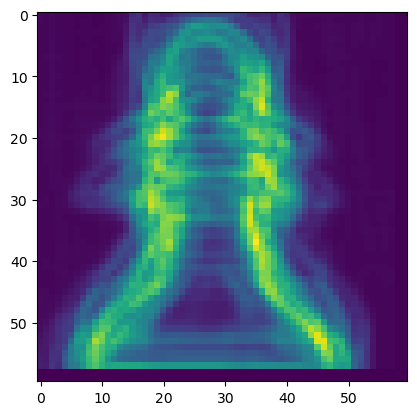

In [35]:
plt.imshow(avg_p_p)

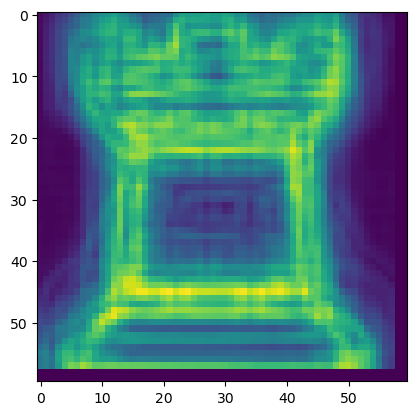

In [36]:
plt.imshow(avg_p_r)

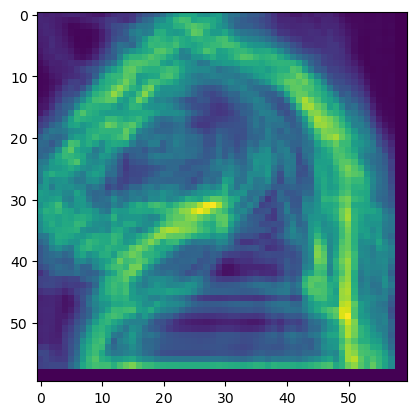

In [37]:
plt.imshow(avg_p_n)

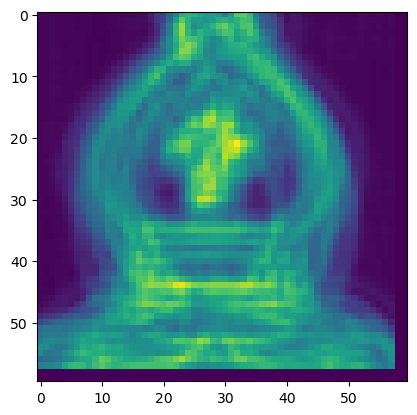

In [38]:
plt.imshow(avg_p_b)

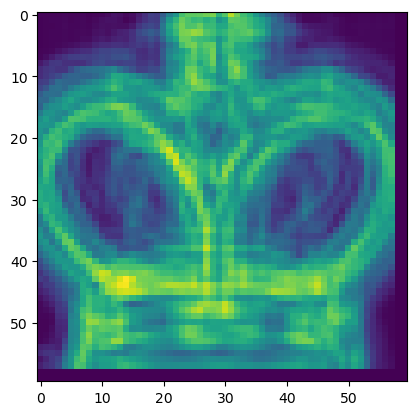

In [39]:
plt.imshow(avg_p_k)

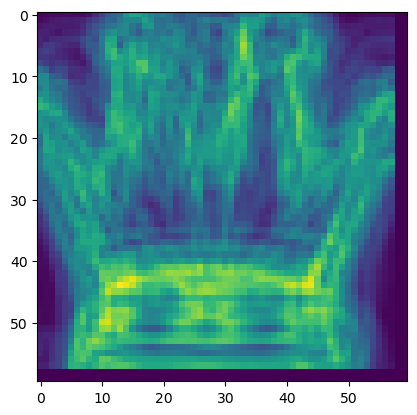

In [40]:
plt.imshow(avg_p_q)

In [37]:
#export avg_prewitts
np.savetxt("ndarray_txt/avg_p_p.txt", avg_p_p, delimiter = " ")
np.savetxt("ndarray_txt/avg_p_r.txt", avg_p_r, delimiter = " ")
np.savetxt("ndarray_txt/avg_p_n.txt", avg_p_n, delimiter = " ")
np.savetxt("ndarray_txt/avg_p_b.txt", avg_p_b, delimiter = " ")
np.savetxt("ndarray_txt/avg_p_k.txt", avg_p_k, delimiter = " ")
np.savetxt("ndarray_txt/avg_p_q.txt", avg_p_q, delimiter = " ")

In [41]:
#distances of each piece type to the avg_prewitts of each piece type
#     (db, dw, lb, lw) positions based on get_board_pieces()
#     p: n%5==4 all (4,4,4,4)
#     r: n%5==3 db, lw; n%5==0 dw, lb (3, 0, 0, 3)
#     n: n%5==0 db, lw; n%5==3 dw, lb (0, 3, 3, 0)
#     b: n%5==2 db, lw; n%5==1 dw, lb (2, 1, 1, 2)
#     k: n%5==1 dw; n%5==2 lb (5, 1, 2, 5)
#     q: n%5==1 db; n%5==2 lw (1, 5, 5, 2)

#pawn
p_p = get_prewitt_distances(4, 4, 4, 4, avg_p_p)
r_p = get_prewitt_distances(3, 0, 0, 3, avg_p_p)
n_p = get_prewitt_distances(0, 3, 3, 0, avg_p_p)
b_p = get_prewitt_distances(2, 1, 1, 2, avg_p_p)
k_p = get_prewitt_distances(5, 2, 2, 5, avg_p_p)
q_p = get_prewitt_distances(1, 5, 5, 1, avg_p_p)

#rook
p_r = get_prewitt_distances(4, 4, 4, 4, avg_p_r)
r_r = get_prewitt_distances(3, 0, 0, 3, avg_p_r)
n_r = get_prewitt_distances(0, 3, 3, 0, avg_p_r)
b_r = get_prewitt_distances(2, 1, 1, 2, avg_p_r)
k_r = get_prewitt_distances(5, 2, 2, 5, avg_p_r)
q_r = get_prewitt_distances(1, 5, 5, 1, avg_p_r)

#knight
p_n = get_prewitt_distances(4, 4, 4, 4, avg_p_n)
r_n = get_prewitt_distances(3, 0, 0, 3, avg_p_n)
n_n = get_prewitt_distances(0, 3, 3, 0, avg_p_n)
b_n = get_prewitt_distances(2, 1, 1, 2, avg_p_n)
k_n = get_prewitt_distances(5, 2, 2, 5, avg_p_n)
q_n = get_prewitt_distances(1, 5, 5, 1, avg_p_n)

#bishop
p_b = get_prewitt_distances(4, 4, 4, 4, avg_p_b)
r_b = get_prewitt_distances(3, 0, 0, 3, avg_p_b)
n_b = get_prewitt_distances(0, 3, 3, 0, avg_p_b)
b_b = get_prewitt_distances(2, 1, 1, 2, avg_p_b)
k_b = get_prewitt_distances(5, 2, 2, 5, avg_p_b)
q_b = get_prewitt_distances(1, 5, 5, 1, avg_p_b)

#king
p_k = get_prewitt_distances(4, 4, 4, 4, avg_p_k)
r_k = get_prewitt_distances(3, 0, 0, 3, avg_p_k)
n_k = get_prewitt_distances(0, 3, 3, 0, avg_p_k)
b_k = get_prewitt_distances(2, 1, 1, 2, avg_p_k)
k_k = get_prewitt_distances(5, 2, 2, 5, avg_p_k)
q_k = get_prewitt_distances(1, 5, 5, 1, avg_p_k)

#queen
p_q = get_prewitt_distances(4, 4, 4, 4, avg_p_q)
r_q = get_prewitt_distances(3, 0, 0, 3, avg_p_q)
n_q = get_prewitt_distances(0, 3, 3, 0, avg_p_q)
b_q = get_prewitt_distances(2, 1, 1, 2, avg_p_q)
k_q = get_prewitt_distances(5, 2, 2, 5, avg_p_q)
q_q = get_prewitt_distances(1, 5, 5, 1, avg_p_q)

In [42]:
#6D points of each piece type; axes in this order: p, r, n, b, k, q
p_points = np.stack((p_p, p_r, p_n, p_b, p_k, p_q), axis=-1)
r_points = np.stack((r_p, r_r, r_n, r_b, r_k, r_q), axis=-1)
n_points = np.stack((n_p, n_r, n_n, n_b, n_k, n_q), axis=-1)
b_points = np.stack((b_p, b_r, b_n, b_b, b_k, b_q), axis=-1)
k_points = np.stack((k_p, k_r, k_n, k_b, k_k, k_q), axis=-1)
q_points = np.stack((q_p, q_r, q_n, q_b, q_k, q_q), axis=-1)

In [43]:
#prep training data for KNN
x_p_train = np.concatenate((p_points, r_points, n_points, b_points, k_points, q_points), axis=0)
y_p_train = np.array([0 for x in range(p_points.shape[0])] + [1 for x in range(r_points.shape[0])] + \
                   [2 for x in range(n_points.shape[0])] + [3 for x in range(b_points.shape[0])] + \
                   [4 for x in range(k_points.shape[0])] + [5 for x in range(q_points.shape[0])])

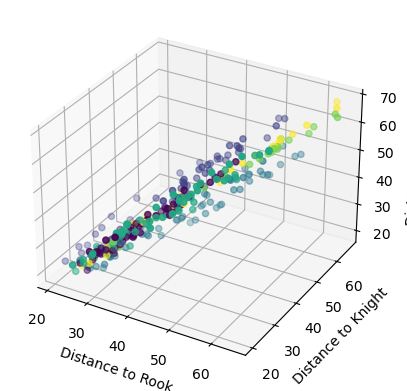

0.9433333333333334


In [52]:
p_knn = KNN(3)
p_knn.fit(x_p_train, y_p_train)
predictions = p_knn.predict(x_p_train)

#colors: red->pawn, yellow->rook, green->knight, cyan->bishop, blue->king, magenta->queen
colors = ListedColormap(["#FF0000", "#FFFA00", "#4DFF00", "#00FFC4", "#0032FF", "#FF00FF"])

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_p_train[:, 1], x_p_train[:, 2], zs=x_p_train[:, 3], zdir='y', c=y_p_train)
ax.set_xlabel('Distance to Rook')
ax.set_ylabel('Distance to Knight')
ax.set_zlabel('Distance to Bishop')
plt.show()

print(np.sum(predictions == y_p_train) / len(y_p_train))

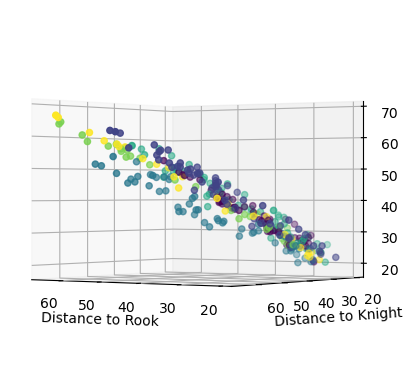

In [63]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_p_train[:, 1], x_p_train[:, 2], zs=x_p_train[:, 3], zdir='y', c=y_p_train)
ax.view_init(elev=0, azim=125, roll=0)
ax.set_xlabel('Distance to Rook')
ax.set_ylabel('Distance to Knight')
ax.set_zlabel('Distance to Bishop')
plt.show()

In [42]:
#export KNN attributes
np.savetxt("ndarray_txt/x_knn.txt", p_knn.X_train, delimiter = " ")
np.savetxt("ndarray_txt/y_knn.txt", p_knn.y_train, delimiter = " ")
np.savetxt("ndarray_txt/k_knn.txt", np.array([p_knn.k]), delimiter = " ")

In [ ]:
########################################################

In [19]:
#########
#ONLY FOR DOCUMENTATION: show inferior accuracy of not separating light and dark svm
#create "average image" for each color piece
def get_avg_img2():
    
    #black pieces
    avg_img_b = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/black_pieces_txt"):
        array = np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}")
        avg_img_b += array
        n += 1
    for txt in os.listdir("light_squares_txt/black_pieces_txt"):
        array = np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}")
        avg_img_b += array
        n += 1
    avg_img_b /= n
    
    #white pieces
    avg_img_w = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/white_pieces_txt"):
        array = np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}")
        avg_img_w += array
        n += 1
    for txt in os.listdir("light_squares_txt/white_pieces_txt"):
        array = np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}")
        avg_img_w += array
        n += 1
    avg_img_w /= n
    
    return [avg_img_b, avg_img_w]

In [20]:
avg_img_b, avg_img_w = get_avg_img2()

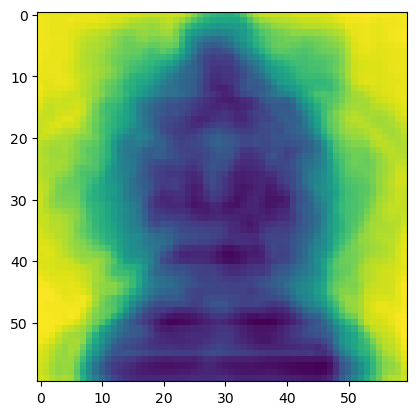

In [21]:
plt.imshow(avg_img_b)

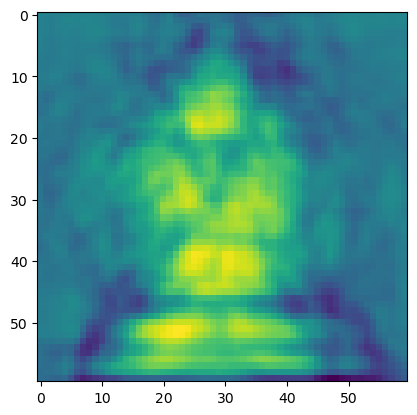

In [23]:
plt.imshow(avg_img_w)

In [49]:
#x: distance to b

b_to_b = get_distances(feature_vector(avg_img_b), "dark_squares_txt/black_pieces_txt")
b_to_w = get_distances(feature_vector(avg_img_w), "dark_squares_txt/black_pieces_txt")
w_to_b = get_distances(feature_vector(avg_img_b), "dark_squares_txt/white_pieces_txt")
w_to_w = get_distances(feature_vector(avg_img_w), "dark_squares_txt/white_pieces_txt")
blk = np.array([(lambda i: np.array([b_to_b[i],b_to_w[i]]))(i) for i in range(b_to_b.size)])
wht = np.array([(lambda i: np.array([w_to_b[i],w_to_w[i]]))(i) for i in range(w_to_b.size)])
x_bw_train = np.concatenate((blk,wht),axis=0)
y_bw_train = np.append((np.ones(blk.shape[0])*-1), np.ones(wht.shape[0])) #white: 1; black: -1


SVM classification accuracy 0.9


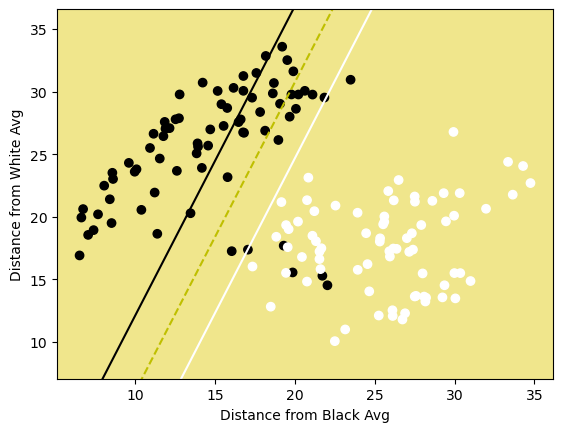

In [50]:
#TEST Training

bw_svm = SVM()
d_svm.fit(x_ds_train, y_ds_train)
predictions = d_svm.predict(x_ds_train)
print("SVM classification accuracy", accuracy(y_ds_train, predictions))
visualize_svm(d_svm, x_ds_train, y_ds_train)

In [171]:
#trying svm for occupancy

In [20]:
avg_do = (avg_img_db + avg_img_dw)/2
avg_lo = (avg_img_lb + avg_img_lw)/2

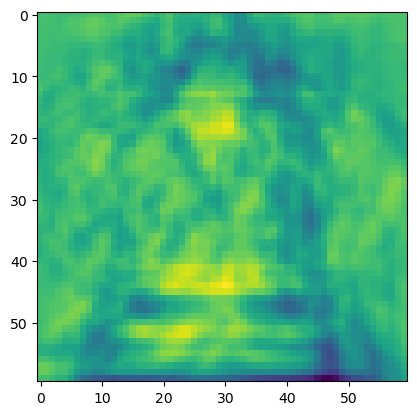

In [21]:
plt.imshow(avg_do)

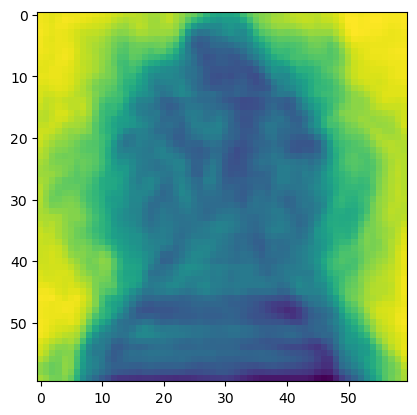

In [22]:
plt.imshow(avg_lo)

In [23]:
#get empty squares
def get_empty_squares(path):
    #initialize number tags
    d = 0
    l = 0
    
    for board_name in os.listdir(path):
        board_path = f"{path}/{board_name}"
        board = imread(resize_board_image(board_path))
        squares = get_squares(grayscale(board))
        
        for i in range(2, 6):
            for j in range(8):
                if i%2 == 0:
                    if j%2 == 0:
                        l += 1
                        save_txt(crop(squares[i,j], 0.125), "empty_squares_txt/light_squares", "l", l)
                    else:
                        d += 1
                        save_txt(crop(squares[i,j], 0.125), "empty_squares_txt/dark_squares", "d", d)
                else:
                    if j%2 == 0:
                        d += 1
                        save_txt(crop(squares[i,j], 0.125), "empty_squares_txt/dark_squares", "d", d)
                    else:
                        l += 1
                        save_txt(crop(squares[i,j], 0.125), "empty_squares_txt/light_squares", "l", l)

In [24]:
def get_avg_empty():
    avg_le = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("empty_squares_txt/light_squares_txt"):
        array = np.loadtxt(f"empty_squares_txt/light_squares_txt/{txt}")
        avg_le += array
        n += 1
    avg_le /= n
    
    avg_de = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("empty_squares_txt/dark_squares_txt"):
        array = np.loadtxt(f"empty_squares_txt/dark_squares_txt/{txt}")
        avg_de += array
        n += 1
    avg_de /= n
    
    return [avg_de, avg_le]
avg_de, avg_le  = get_avg_empty()

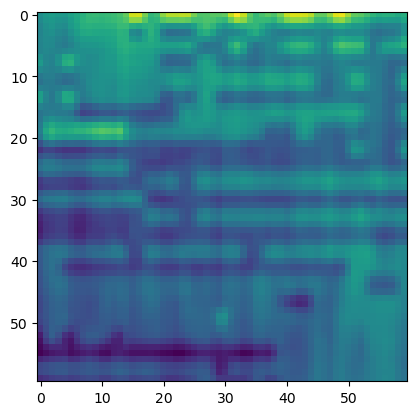

In [28]:
plt.imshow(avg_de)

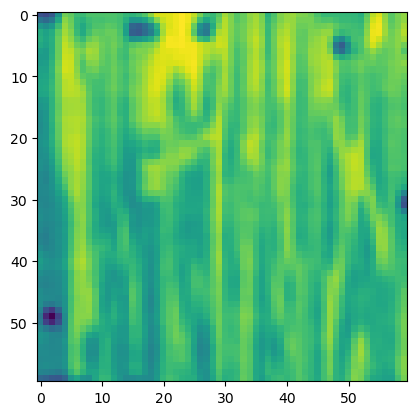

In [26]:
plt.imshow(avg_le)

In [30]:
#x: distance to avg_occupied; y: distance to avg_empty

#dark
#occupied to avg
d_b_to_o = get_distances(feature_vector(avg_do), "dark_squares_txt/black_pieces_txt")
d_w_to_o = get_distances(feature_vector(avg_do), "dark_squares_txt/white_pieces_txt")
d_o_to_o = np.concatenate((d_b_to_o, d_w_to_o), axis=0) #dark occupied x

d_b_to_e = get_distances(feature_vector(avg_de), "dark_squares_txt/black_pieces_txt")
d_w_to_e = get_distances(feature_vector(avg_de), "dark_squares_txt/white_pieces_txt")
d_o_to_e = np.concatenate((d_b_to_e, d_w_to_e), axis=0) #dark occupied y

#empty to avg
d_e_to_o = get_distances(feature_vector(avg_do), "empty_squares_txt/dark_squares_txt") #dark empty x
d_e_to_e = get_distances(feature_vector(avg_de), "empty_squares_txt/dark_squares_txt") #dark empty y

do = np.array([(lambda i: np.array([d_o_to_o[i], d_o_to_e[i]]))(i) for i in range(d_o_to_o.size)])
de = np.array([(lambda i: np.array([d_e_to_o[i], d_e_to_e[i]]))(i) for i in range(d_e_to_o.size)])

x_de_train = np.concatenate((do,de),axis=0)
y_de_train = np.append((np.ones(do.shape[0])*-1), np.ones(de.shape[0]))

###########################

# # light
# #occupied to avg
# l_b_to_o = get_distances(feature_vector(avg_occupied), "light_squares_txt/black_pieces_txt")
# l_w_to_o = get_distances(feature_vector(avg_occupied), "light_squares_txt/white_pieces_txt")
# l_o_to_o = np.concatenate((d_b_to_o, d_w_to_o), axis=0) #light occupied x

# l_b_to_e = get_distances(feature_vector(avg_empty), "light_squares_txt/black_pieces_txt")
# l_w_to_e = get_distances(feature_vector(avg_empty), "light_squares_txt/white_pieces_txt")
# l_o_to_e = np.concatenate((d_b_to_e, d_w_to_e), axis=0) #light occupied y

# #empty to avg
# l_e_to_o = get_distances(feature_vector(avg_occupied), "empty_squares_text/light_squares_txt") #light empty x
# l_e_to_e = get_distances(feature_vector(avg_empty), "empty_squares_text/light_squares_txt") #light empty y




SVM classification accuracy 0.6153846153846154


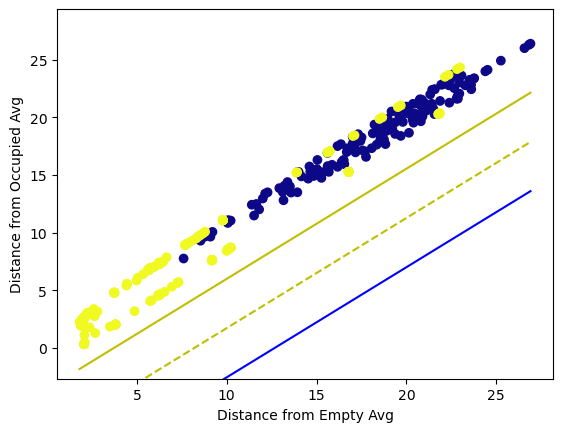

In [68]:
#dark empty squares
def visualize_svm_e(svm, X, y):
    def get_hyperplane_value(x, weights, bias, offset):
        return (-weights[0] * x + bias + offset) / weights[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, cmap="plasma")
    plt.xlabel("Distance from Empty Avg")
    plt.ylabel("Distance from Occupied Avg")

    dx_1 = np.amin(X[:, 0])
    dx_2 = np.amax(X[:, 0])

    dy_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, 0)
    dy_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, 0)

    by_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, -1)
    by_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, -1)

    wy_1 = get_hyperplane_value(dx_1, svm.weights, svm.bias, 1)
    wy_2 = get_hyperplane_value(dx_2, svm.weights, svm.bias, 1)

    ax.plot([dx_1, dx_2], [dy_1, dy_2], "y--") # decision boundary
    ax.plot([dx_1, dx_2], [by_1, by_2], "b") # black sv 
    ax.plot([dx_1, dx_2], [wy_1, wy_2], "y") # white sv
    
    dy_min = np.amin(X[:, 1])
    dy_max = np.amax(X[:, 1])
    ax.set_ylim([dy_min - 3, dy_max + 3])

    plt.show()

de_svm = SVM()
de_svm.fit(x_de_train, y_de_train)
predictions = de_svm.predict(x_de_train)
print("SVM classification accuracy", accuracy(y_de_train, predictions))
visualize_svm_e(de_svm, x_de_train, y_de_train)

In [51]:
#ONLY FOR DOCUMENTATION
#########

In [70]:
#Metrics

#import correct outputs
actual = []
for output in os.listdir("test_boards_txt"):
    piece_array = []
    file = open(f"test_boards_txt/{output}", "r")
    string = file.read()
    rows = string.split("\n")
    for row in rows:
        piece_array.append(row.split())
    actual.append(piece_array)
    file.close()

#import correct outputs
predicted = []
for output in os.listdir("test_boards_predictions"):
    piece_array = []
    file = open(f"test_boards_predictions/{output}", "r")
    string = file.read()
    rows = string.split("\n")
    for row in rows:
        piece_array.append(row.split())
    predicted.append(piece_array)
    file.close()

In [ ]:
# Accuracy, Precision, Recall, F1 score for each square color and piece color
# Accuracy, Precision, Recall, F1 score for each piece type

# Accuracy = total correct predictions / total predictions made
# Precision = True positives / True positives + false positives
# Recall = True positives / true positives + false negatives
# F1 score = 2/((1/precision)+(1/recall))

In [74]:
#D_SVM
#black
db_tp = 0
db_fn = 0
db_fp = 0
db_tn = 0
db_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if i+j%2 == 1:
                if char != "_":
                    db_total += 1
                    if char.islower():
                        if predicted[k][i][j].islower():
                            db_tp += 1
                        else:
                            db_fn += 1
                    elif char.isupper():
                        if predicted[k][i][j].islower():
                            db_fp += 1
                        else:
                            db_tn += 1

db_accuracy = (db_tp+db_tn)/db_total
db_precision = db_tp/(db_tp+db_fp)
db_recall = db_tp/(db_tp+db_fn)
db_f1 = 2/((1/db_precision)+(1/db_recall))
print(f"DB: accuracy={db_accuracy}, precision={db_precision}, recall ={db_recall}, f1={db_f1}")

#white
dw_tp = 0
dw_fn = 0
dw_fp = 0
dw_tn = 0
dw_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if i+j%2 == 1:
                if char != "_":
                    dw_total += 1
                    if char.isupper():
                        if predicted[k][i][j].isupper():
                            dw_tp += 1
                        else:
                            dw_fn += 1
                    elif char.islower():
                        if predicted[k][i][j].isupper():
                            dw_fp += 1
                        else:
                            dw_tn += 1
    
dw_accuracy = (dw_tp+dw_tn)/dw_total
dw_precision = dw_tp/(dw_tp+dw_fp)
dw_recall = dw_tp/(dw_tp+dw_fn)
dw_f1 = 2/((1/dw_precision)+(1/dw_recall))
print(f"DW: accuracy={dw_accuracy}, precision={dw_precision}, recall ={dw_recall}, f1={dw_f1}")

DB: accuracy=0.9932885906040269, precision=1.0, recall =0.9904761904761905, f1=0.9952153110047847
DW: accuracy=0.9731543624161074, precision=1.0, recall =0.9090909090909091, f1=0.9523809523809523


In [75]:
#L_SVM
#black
lb_tp = 0
lb_fn = 0
lb_fp = 0
lb_tn = 0
lb_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if i+j%2 == 0:
                if char != "_":
                    lb_total += 1
                    if char.islower():
                        if predicted[k][i][j].islower():
                            lb_tp += 1
                        else:
                            lb_fn += 1
                    elif char.isupper():
                        if predicted[k][i][j].islower():
                            lb_fp += 1
                        else:
                            lb_tn += 1

lb_accuracy = (lb_tp+lb_tn)/lb_total
lb_precision = lb_tp/(lb_tp+lb_fp)
lb_recall = lb_tp/(lb_tp+lb_fn)
lb_f1 = 2/((1/lb_precision)+(1/lb_recall))
print(f"LB: accuracy={lb_accuracy}, precision={lb_precision}, recall ={lb_recall}, f1={lb_f1}")

#white
lw_tp = 0
lw_fn = 0
lw_fp = 0
lw_tn = 0
lw_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if i+j%2 == 0:
                if char != "_":
                    lw_total += 1
                    if char.isupper():
                        if predicted[k][i][j].isupper():
                            lw_tp += 1
                        else:
                            lw_fn += 1
                    elif char.islower():
                        if predicted[k][i][j].isupper():
                            lw_fp += 1
                        else:
                            lw_tn += 1
    
lw_accuracy = (lw_tp+lw_tn)/lw_total
lw_precision = lw_tp/(lw_tp+lw_fp)
lw_recall = lw_tp/(lw_tp+lw_fn)
lw_f1 = 2/((1/lw_precision)+(1/lw_recall))
print(f"LW: accuracy={lw_accuracy}, precision={lw_precision}, recall ={lw_recall}, f1={lw_f1}")

LB: accuracy=1.0, precision=1.0, recall =1.0, f1=1.0
LW: accuracy=0.9655172413793104, precision=1.0, recall =0.8888888888888888, f1=0.9411764705882353


In [80]:
print(db_total, lw_total)

149 58


In [85]:
#KNN
#pawn
p_tp = 0
p_fn = 0
p_fp = 0
p_tn = 0
p_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                p_total += 1
                if char.upper() == "P":
                    if predicted[k][i][j].upper() == "P":
                        p_tp += 1
                    else:
                        p_fn += 1
                elif char.upper() != "P":
                    if predicted[k][i][j].upper() == "P":
                        p_fp += 1
                    else:
                        p_tn += 1

p_accuracy = (p_tp+p_tn)/p_total
p_precision = p_tp/(p_tp+p_fp)
p_recall = p_tp/(p_tp+p_fn)
p_f1 = 2/((1/p_precision)+(1/p_recall))
print(f"P: accuracy={p_accuracy}, precision={p_precision}, recall ={p_recall}, f1={p_f1}")

#rook
r_tp = 0
r_fn = 0
r_fp = 0
r_tn = 0
r_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                r_total += 1
                if char.upper() == "R":
                    if predicted[k][i][j].upper() == "R":
                        r_tp += 1
                    else:
                        r_fn += 1
                elif char.upper() != "R":
                    if predicted[k][i][j].upper() == "R":
                        r_fp += 1
                    else:
                        r_tn += 1

r_accuracy = (r_tp+r_tn)/r_total
r_precision = r_tp/(r_tp+r_fp)
r_recall = r_tp/(r_tp+r_fn)
r_f1 = 2/((1/r_precision)+(1/r_recall))
print(f"R: accuracy={r_accuracy}, precision={r_precision}, recall ={r_recall}, f1={r_f1}")

#knight
n_tp = 0
n_fn = 0
n_fp = 0
n_tn = 0
n_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                n_total += 1
                if char.upper() == "N":
                    if predicted[k][i][j].upper() == "N":
                        n_tp += 1
                    else:
                        n_fn += 1
                elif char.upper() != "N":
                    if predicted[k][i][j].upper() == "N":
                        n_fp += 1
                    else:
                        n_tn += 1

n_accuracy = (n_tp+n_tn)/n_total
n_precision = n_tp/(n_tp+n_fp)
n_recall = n_tp/(n_tp+n_fn)
n_f1 = 2/((1/n_precision)+(1/n_recall))
print(f"N: accuracy={n_accuracy}, precision={n_precision}, recall ={n_recall}, f1={n_f1}")

#bishop
b_tp = 0
b_fn = 0
b_fp = 0
b_tn = 0
b_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                b_total += 1
                if char.upper() == "B":
                    if predicted[k][i][j].upper() == "B":
                        b_tp += 1
                    else:
                        b_fn += 1
                elif char.upper() != "B":
                    if predicted[k][i][j].upper() == "B":
                        b_fp += 1
                    else:
                        b_tn += 1

b_accuracy = (b_tp+b_tn)/b_total
b_precision = b_tp/(b_tp+b_fp)
b_recall = b_tp/(b_tp+b_fn)
b_f1 = 2/((1/b_precision)+(1/b_recall))
print(f"B: accuracy={b_accuracy}, precision={b_precision}, recall ={b_recall}, f1={b_f1}")

#king
k_tp = 0
k_fn = 0
k_fp = 0
k_tn = 0
k_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                k_total += 1
                if char.upper() == "K":
                    if predicted[k][i][j].upper() == "K":
                        k_tp += 1
                    else:
                        k_fn += 1
                elif char.upper() != "K":
                    if predicted[k][i][j].upper() == "K":
                        k_fp += 1
                    else:
                        k_tn += 1

k_accuracy = (k_tp+k_tn)/k_total
k_precision = k_tp/(k_tp+k_fp)
k_recall = k_tp/(k_tp+k_fn)
k_f1 = 2/((1/k_precision)+(1/k_recall))
print(f"K: accuracy={k_accuracy}, precision={k_precision}, recall ={k_recall}, f1={k_f1}")

#queen
q_tp = 0
q_fn = 0
q_fp = 0
q_tn = 0
q_total = 0
for k, output in enumerate(actual):
    for i, row in enumerate(output):
        for j, char in enumerate(row):
            if char != "_":
                q_total += 1
                if char.upper() == "Q":
                    if predicted[k][i][j].upper() == "Q":
                        q_tp += 1
                    else:
                        q_fn += 1
                elif char.upper() != "Q":
                    if predicted[k][i][j].upper() == "Q":
                        q_fp += 1
                    else:
                        q_tn += 1

q_accuracy = (q_tp+q_tn)/q_total
q_precision = q_tp/(q_tp+q_fp)
q_recall = q_tp/(q_tp+q_fn)
q_f1 = 2/((1/q_precision)+(1/q_recall))
print(f"Q: accuracy={q_accuracy}, precision={q_precision}, recall ={q_recall}, f1={q_f1}")

P: accuracy=0.8381201044386423, precision=0.9818840579710145, recall =0.6948717948717948, f1=0.8138138138138138
R: accuracy=0.8263707571801566, precision=0.4117647058823529, recall =0.5943396226415094, f1=0.4864864864864864
N: accuracy=0.8590078328981723, precision=0.3902439024390244, recall =0.5925925925925926, f1=0.47058823529411764
B: accuracy=0.8890339425587467, precision=0.4752475247524752, recall =0.6, f1=0.5303867403314916
K: accuracy=0.9399477806788512, precision=0.6944444444444444, recall =0.4166666666666667, f1=0.5208333333333334
Q: accuracy=0.9295039164490861, precision=0.4418604651162791, recall =0.3877551020408163, f1=0.41304347826086957


In [87]:
print(p_total)

766
